# Homework 3 - Group 17

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

class GridWorld:

    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.agent = [0, 0]
        self.goal = [self.height - 1, self.width - 1]
        self.wall = [3, 2]
        self.trap = [2, 2]
        self.num_actions = 4
        self.actions = [0,1,2,3]
       

    def step(self, direction):
        """perform a step of the agent in a given direction and give a reward for the action"""

        row, col = self.agent

        #move right
        if direction == 0:
            if col < self.width - 1 and [row, col + 1] != self.wall:
                col += 1

        #move left
        elif direction == 1:
            if col > 0 and [row, col - 1] != self.wall:
                col -= 1
        #move up
        elif direction == 2:
            if row > 0 and [row - 1, col] != self.wall:
                row -= 1

        #move down
        elif direction == 3:
            if row < self.height - 1 and [row + 1, col] != self.wall:
                row += 1

        self.agent = [row, col]

        #check if agent reached the goal
        done = (self.agent == self.goal)

        #give reward
        if self.agent == self.trap:
            reward = -1

        elif self.agent == self.goal:
            reward = 1 
        else: 
            reward = -0.1

        return self.agent, reward, done

    def reset(self):
        """reset of the gridworld to the starting state"""
        self.agent = [0, 0]
        return self.agent

    def evaluate(self):
        """evaluate current position and check which actions lead closer to the goal"""
        #check current position to goal
        row, col = self.agent
        row_goal, col_goal = self.goal
        position_to_goal = [row_goal - row, col_goal - col]

        #check which actions lead closer to the goal
        useful_actions = []
        if position_to_goal[0] > 0: #down
            useful_actions.append(3)

        elif position_to_goal[0] < 0: #up
            useful_actions.append(2)

        if position_to_goal[1] > 0: #right
            useful_actions.append(0)

        elif position_to_goal[1] < 0: #left
            useful_actions.append(1)
        
        return useful_actions
    

    def render(self):
        """visualization, mainly for debugging"""
        grid = np.zeros((self.height, self.width), dtype=str)
        grid[self.agent[0], self.agent[1]] = "A"
        grid[self.goal[0], self.goal[1]] = "G"
        grid[self.wall[0], self.wall[1]] = "W"
        grid[self.trap[0], self.trap[1]] = "T"
        print(grid)

    def epsilon_greedy_policy(self, Q, state, epsilon=0.1):
        """epsilon greedy policy to determine which action the agent chooses. Move random with prob=epsilon else choose action with the highest q-value"""
        if np.random.rand() < epsilon: # choose the action depending on the soft policy
            return np.random.choice(self.actions)

        else: # choose the action with the maximum q-value
            q_values = Q[state[0], state[1], :]
            max_q = np.max(q_values)
            max_indices = np.where(q_values == max_q)[0]
            return np.random.choice(max_indices) #if there is two actions with same maximum value then it will choose randomly from these two 

    def mc_estimation(self, n_epochs=1000, gamma=0.99, epsilon=0.1): 
        """Implementation of mc_estimation"""   
        # Initialize empty dictionaries to store returns and counts for each state     
        Q_MC = np.zeros((self.height, self.width,self.num_actions))
        count = np.zeros((self.height, self.width, self.num_actions))
        #get a variable to accumulate the rewards of all epochs
        total_reward = 0 
        average_reward = []
        
        # Run n_epochs epochs
        for epoch in range(n_epochs):
            episode = []
            state = self.reset()
            done = False

            while not done:
                action = self.epsilon_greedy_policy(Q_MC, state)

                #step and save state, action and reward for mc estimate
                next_state, reward, done = self.step(action)
                episode.append((state, action, reward))
                state = next_state

            G = 0 # total discounted return the agent receive after making an action in specific state
            #visited = np.zeros((self.width, self.height), dtype=bool)
            for t in range(len(episode) - 1, -1, -1):
                state, action, reward = episode[t]
                G = gamma * G + reward # update the G
                count[state[0], state[1], action] += 1 # update the count
                # update the Q value, N represent the number of times the sate and the action has been visted
                Q_MC[state[0], state[1], action] +=  (G - Q_MC[state[0], state[1], action]) / count[state[0], state[1], action]
            total_reward += G
            average_reward.append(total_reward / (epoch + 1))

        # empty list to save the q-values
        policy = np.zeros((self.height, self.width), dtype=int)
        for i in range(self.height):
            for j in range(self.width):
                policy[i, j] = np.argmax(Q_MC[i, j, :]) # adding the q-value to the policy list

        return Q_MC, policy, average_reward

    def sarsa(self, n_epochs=1000, gamma=0.99, alpha=0.1):
        """Implementation of 1-step tabular sarsa"""
        # Initialize empty dictionaries to store returns and counts for each state
        Q_SARSA = np.zeros((self.height, self.width,self.num_actions))

        #get a variable to accumulate the rewards of all epochs
        total_reward = 0 
        average_reward = []

        for epoch in range(n_epochs):
            #episode = []
            state = self.reset()
            done = False
            action = self.epsilon_greedy_policy(Q_SARSA, state)

            while not done:
                next_state, reward, done = self.step(action)
                next_action = self.epsilon_greedy_policy(Q_SARSA, next_state)
                td_error = reward + gamma * Q_SARSA[next_state[0], next_state[1], next_action] - Q_SARSA[state[0], state[1], action]
                Q_SARSA[state[0], state[1], action] += alpha * td_error
                state = next_state
                action = next_action
                total_reward += reward
            
            average_reward.append(total_reward / (epoch + 1))

        return Q_SARSA, average_reward

    
    def plot_average_return(self, returns, time, n_epochs=1000):
        """plotting of the average return per episode"""
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        fig.subplots_adjust(wspace=0.3)
        fig.suptitle('Average Return per Episode')
        ax1.plot(range(n_epochs), returns)
        ax1.set_xlabel('number of episodes')
        ax2.set_xlabel('runtime in seconds')
        ax2.plot(np.linspace(0, time, 1000), returns)
        plt.show()


### Adjusted Algorithms with state tracking for exercise 3 

In [52]:
def sarsa(env, q_values_start, iterator, n_epochs=1000, gamma=0.99, alpha=0.1):
    """Adjusted Implementation of 1-step tabular sarsa for exercise 3"""
    # Initialize empty dictionaries to store returns and counts for each state
    Q_SARSA = np.zeros((env.height, env.width,env.num_actions))

    for epoch in range(n_epochs):
        #episode = []
        state = env.reset()
        done = False
        action = 0 #set first action = right

        while not done:
            next_state, reward, done = env.step(action)
            next_action = env.epsilon_greedy_policy(Q_SARSA, next_state)
            td_error = reward + gamma * Q_SARSA[next_state[0], next_state[1], next_action] - Q_SARSA[state[0], state[1], action]
            Q_SARSA[state[0], state[1], action] += alpha * td_error
            state = next_state
            action = next_action

        q_values_start[iterator, epoch] = Q_SARSA[0, 0, 0]

    return q_values_start

def mc_estimation(env, q_values_start, iterator, n_epochs=1000, gamma=0.99, epsilon=0.1): 
    """Adjusted Implementation of mc_estimation for exercise 3"""   
    # Initialize empty dictionaries to store returns and counts for each state     
    Q_MC = np.zeros((env.height, env.width,env.num_actions))
    count = np.zeros((env.height, env.width, env.num_actions))
    
    # Run n_epochs epochs
    for epoch in range(n_epochs):
        episode = []
        state = env.reset()
        done = False
        first = False
        #first move always right
        while not done:
            if first == False:
                action = 0
                first = True
            else:
                action = env.epsilon_greedy_policy(Q_MC, state)

            #step and save state, action and reward for mc estimate
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        G = 0 # total discounted return the agent receive after making an action in specific state
        #visited = np.zeros((self.width, self.height), dtype=bool)
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward # update the G
            count[state[0], state[1], action] += 1 # update the count
            # update the Q value, N represent the number of times the state and the action has been visted
            Q_MC[state[0], state[1], action] +=  (G - Q_MC[state[0], state[1], action]) / count[state[0], state[1], action]

        q_values_start[iterator, epoch] = Q_MC[0, 0, 0]

    # empty list to save the q-values
    policy = np.zeros((env.height, env.width), dtype=int)
    for i in range(env.height):
        for j in range(env.width):
            policy[i, j] = np.argmax(Q_MC[i, j, :]) # adding the q-value to the policy list

    return q_values_start

In [53]:
env_mc = GridWorld(4, 4)
env_sarsa = GridWorld(4, 4)

#empty arrays for tracking of the q_value
q_values_sarsa = np.zeros((100, 1000))
q_values_mc = np.zeros((100, 1000))
for i in range(100):
    q_values_sarsa = sarsa(env_sarsa, q_values_sarsa, i)
    q_values_mc = mc_estimation(env_mc, q_values_mc, i)

#take mean and std
q_values_sarsa_mean = np.mean(q_values_sarsa, axis=0, keepdims=False)
q_values_sarsa_std = np.std(q_values_sarsa, axis=0, keepdims=False)
q_values_mc_mean = np.mean(q_values_mc, axis=0, keepdims=False)
q_values_mc_std = np.std(q_values_mc, axis=0, keepdims=False)

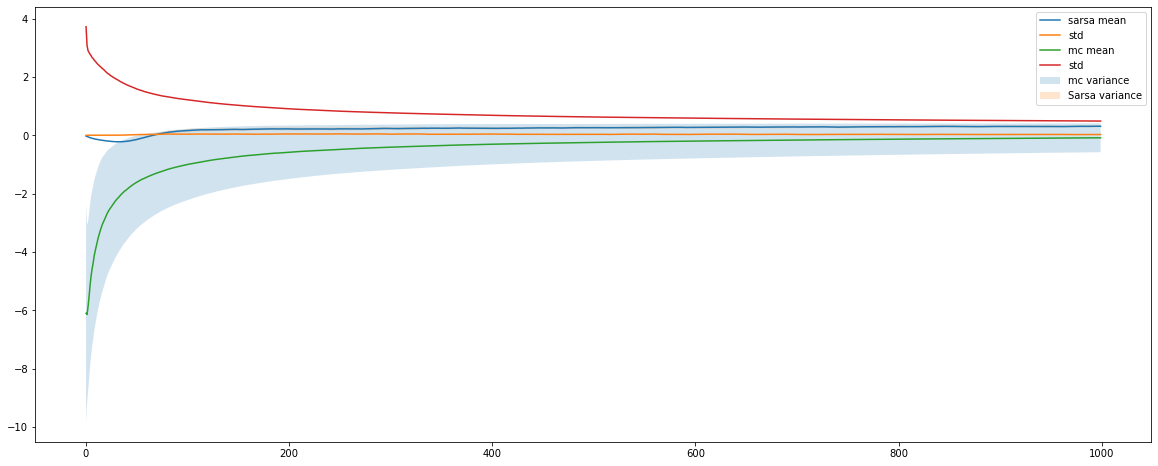

In [56]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(q_values_sarsa_mean, label='sarsa mean')
ax.plot(q_values_sarsa_std, label='std')
ax.plot(q_values_mc_mean, label='mc mean')
ax.plot(q_values_mc_std, label='std')
ax.fill_between(range(len(q_values_mc_mean)),q_values_mc_mean+q_values_mc_std,q_values_mc_mean-q_values_mc_std,alpha=0.2,label='mc variance')
ax.fill_between(range(len(q_values_sarsa_mean)),q_values_sarsa_mean+q_values_sarsa_std,q_values_sarsa_mean-q_values_sarsa_std,alpha=0.2,label='Sarsa variance')
#axes[0].set_title('sarsa')
#axes[1].set_title('mc')
ax.legend()
#axes[1].legend()


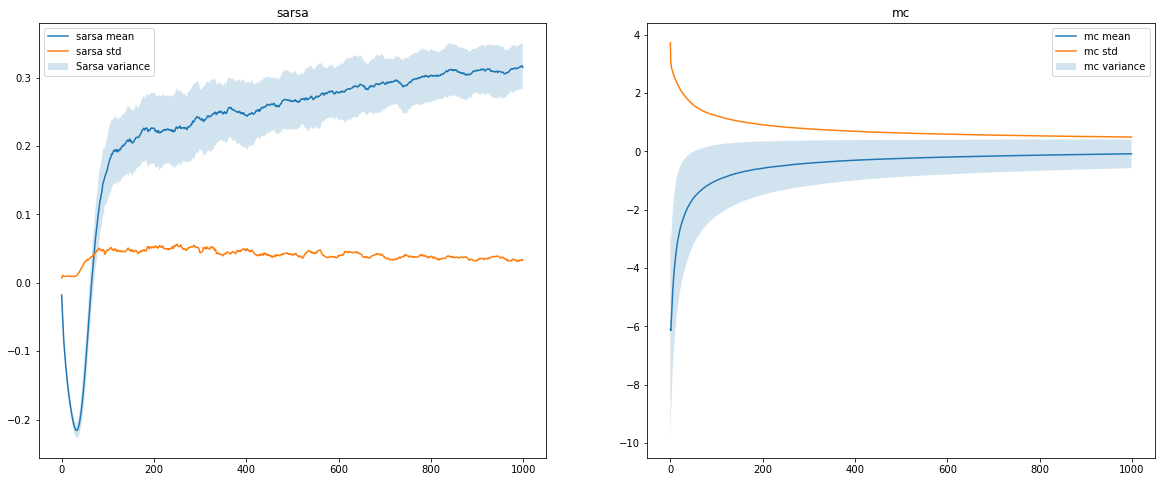

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
ax[0].plot(q_values_sarsa_mean, label='sarsa mean')
ax[0].plot(q_values_sarsa_std, label='sarsa std')
ax[1].plot(q_values_mc_mean, label='mc mean')
ax[1].plot(q_values_mc_std, label='mc std')
ax[1].fill_between(range(len(q_values_mc_mean)),q_values_mc_mean+q_values_mc_std,q_values_mc_mean-q_values_mc_std,alpha=0.2,label='mc variance')
ax[0].fill_between(range(len(q_values_sarsa_mean)),q_values_sarsa_mean+q_values_sarsa_std,q_values_sarsa_mean-q_values_sarsa_std,alpha=0.2,label='Sarsa variance')
ax[0].set_title('sarsa')
ax[1].set_title('mc')
ax[0].legend()
ax[1].legend()

* variance
- the result shows that the variance in SARSA (between 0.0 and 0.1) is less than the variance in monte carlo (between 0 and 4) This is because MC methods rely on the observed returns, which can vary significantly from one episode to another. The variability in the returns leads to higher variance in the estimated values.while sarsa update their estimates after each action, taking into account the immediate reward and the estimated value of the next state-action pair. This allows for a more gradual and less variable update process, which reduces the variance.
- in the sarsa the variance is kind of uniform, while the variance started high and then decrease gradually.

* bias
- MC methods generally have low bias because they do not make any assumptions about the underlying dynamics of the environment. They learn directly from the observed returns without assuming any Markov property or model structure.
- SARSA methods can have a higher bias compared to MC methods because they make certain assumptions about the environment dynamics. SARSA assumes that the agent's future actions will follow the same policy it is currently following. If the policy is suboptimal or deviates from the true optimal policy